# Make  spectra average
=======================================



- Author Sylvie Dagoret-Campagne
- Creation date Friday 5th 2016


## Import packages
-------------------------

In [374]:
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [375]:
def smooth(x,window_len=11,window='hanning'):
    """
    smooth the data using a window with requested size.     
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
     (with the window size) in both ends so that transient parts are minimized
     in the begining and end part of the output signal.     
     input:
     x: the input signal 
     window_len: the dimension of the smoothing window; should be an odd integer
     window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman
     flat window will produce a moving average smoothing.

     output:
        the smoothed signal         
        example:
 
         t=linspace(-2,2,0.1)
         x=sin(t)+randn(len(t))*0.1
         y=smooth(x)
         
         see also: 
           
         numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
           scipy.signal.lfilter
    
           TODO: the window parameter could be the window itself if an array instead of a string
           NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
       """ 
      
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."
 
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
 
    if window_len<3:
        return x
   
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
       
  
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
     
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y    

In [376]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [377]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-11 11:56:08.204980
fits date format for the analysis :  2016-07-11T11:56:08


In [378]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Few definitions
-----------------------

- file index
- object name
- filename
- path

### Night 2016/05/11

In [379]:
# definition for the series of images
#FactorPredToData=2.5e14
#fileindex_start=103;  # file number
#fileindex_stop=112;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/11, Nimg='+str(fileindexes.shape[0]) +', expo=5s, am=1.1' 
#infofig='hd158485_grat_0511_'+str(fileindex_start)+'_'+str(fileindex_stop)

In [380]:
# definition for the series of images
#FactorPredToData=2.5e14
#fileindex_start=52;  # file number
#fileindex_stop=71;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/11, Nimg='+str(fileindexes.shape[0]) +', expo=5s, am=1.2' 
#infofig='hd158485_grat_0511_'+str(fileindex_start)+'_'+str(fileindex_stop)

In [381]:
# definition for the series of images
#FactorPredToData=2.5e14
#fileindex_start=22;  # file number
#fileindex_stop=31;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/11, Nimg='+str(fileindexes.shape[0]) +', expo=5s, am=1.43' 
#infofig='hd158485_grat_0511_'+str(fileindex_start)+'_'+str(fileindex_stop)

In [382]:
# definition for the series of images
#FactorPredToData=2.5e14
#fileindex_start=7;  # file number
#fileindex_stop=16;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/11, Nimg='+str(fileindexes.shape[0]) +', expo=5s, am=1.77' 
#infofig='hd158485_grat_0511_'+str(fileindex_start)+'_'+str(fileindex_stop)

### Night 2016/05/09

In [383]:
# definition for the series of images
FactorPredToData=2.3e14
fileindex_start=2;  # file number
fileindex_stop=25;
fileindexes=np.arange(fileindex_start,fileindex_stop+1)
info='obj HD158485_grat_, 05/09, Nimg='+str(fileindexes.shape[0]) +', expo=1.5s, am=1.1' 
infofig='hd158485_grat_0509_'+str(fileindex_start)+'_'+str(fileindex_stop)

### Night 2016/05/10

In [384]:
# definition for the series of images
FactorPredToData=2.3e14
fileindex_start=2;  # must remove the first image because goes not with the others
fileindex_stop=13;
fileindexes=np.arange(fileindex_start,fileindex_stop+1)
info='obj HD158485_grat_, 05/10, Nimg='+str(fileindexes.shape[0]) +', expo=1.5-5s, am=1.1' 
infofig='hd158485_grat_0510_'+str(fileindex_start)+'_'+str(fileindex_stop)

In [385]:
object_name='HD158485_grat_' # object name

In [386]:
#path
#path_spectrum=path='../MyReduction_2016_05_11/HD158485_grat'+'_spectra'   # path where is the spectra
#path_spectrum=path='../MyReduction_2016_05_09/HD158485_grat'+'_spectra'   # path where is the spectra
path_spectrum=path='../MyReduction_2016_05_10/HD158485_grat'+'_spectra'   # path where is the spectra

In [387]:
file_list=[os.path.join(path_spectrum,'dataspec_'+object_name+str(filenum)+'.fits' ) for filenum in fileindexes]

In [388]:
file_list

['../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_2.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_3.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_4.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_5.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_6.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_7.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_8.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_9.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_10.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_11.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_12.fits',
 '../MyReduction_2016_05_10/HD158485_grat_spectra/dataspec_HD158485_grat_13.fits']

In [389]:
NBFILES=len(file_list)

In [390]:
print NBFILES

12


## Read the files
---------------------------


In [391]:
spectra_list = []      # list of experimental spectra
wavelength_list = []   # wavelength table of experimental spectra
obspred_list = []      # list of predicted spectra
wavelengthobspred_list = []  # list of wavelength for predicted spectra
atm_list= []

### A) Open the files

- open and read each of the fits file
- fill the list booked above


In [392]:
for thefile in file_list:
    hdulist=fits.open(thefile) 
    # spectra
    table_data1=hdulist[1].data  # get only the data not the prediction
    specdata_wavelength=table_data1.field('WAVELENGTH')
    specdata_flux=table_data1.field('SPECTRUMDATA')
    
    spectra_list.append(specdata_flux)
    wavelength_list.append(specdata_wavelength)
    # prediction
    table_data2=hdulist[2].data    
    wavelength_sed=table_data2.field('WAVELENGTH')
    flux_sed=table_data2.field('SEDcalspec')*(wavelength_sed/900.)  # convert in number of photons per wl bin
    flux_sedccd=table_data2.field('SEDxQE')*(wavelength_sed/900.)   # convert in number of photons per wl bin
    flux_sedccdatm=table_data2.field('SEDxQExATM')*(wavelength_sed/900.) # convert in number of photons per wl bin
    flux_sedccdatmopt=table_data2.field('SEDxQExATMxTopt')*(wavelength_sed/900.) # convert in number of photons per wl bin
    atm=np.where(flux_sedccd>0,flux_sedccdatm/flux_sedccd,0)  # retrieve the atmospheric profile
    #obspred_list.append(flux_sedccdatmopt) # select the prediction with CCD, atmosphere and optical throughput
    obspred_list.append(flux_sedccdatm) # select the prediction with CCD, atmosphere but not optical throughput
    wavelengthobspred_list.append(wavelength_sed)
    atm_list.append(atm)  
    hdulist.close()

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


## Shows the atmosphere

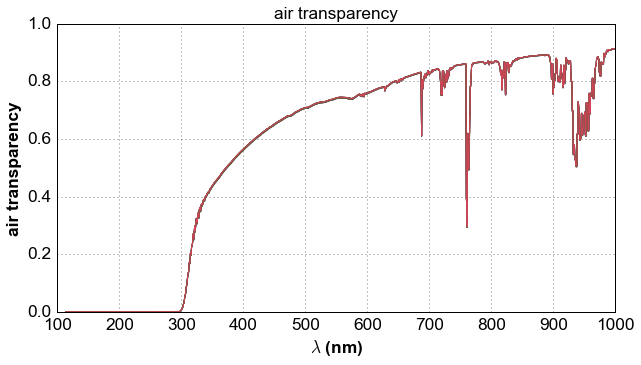

In [393]:
plt.figure(figsize=(10,5))
for idx,atm in enumerate(atm_list):
    plt.plot(wavelengthobspred_list[idx],atm_list[idx])
plt.title('air transparency')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('air transparency')

## Shows the experimental spectra

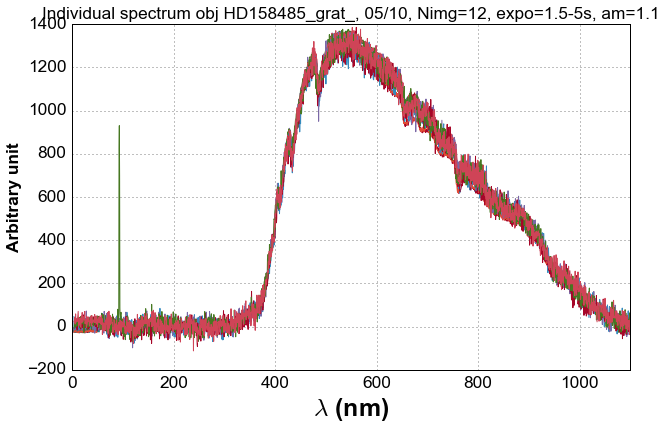

In [394]:
figname='IndividualSpectrumLin_'+infofig +'.pdf'
plt.figure(figsize=(10.,6.))
for idx in range(NBFILES):    
    plt.plot(wavelength_list[idx],spectra_list[idx],linewidth=1.0)

title='Individual spectrum '+info
plt.title(title)
plt.xlabel('$\lambda$ (nm)',fontsize=25)
plt.ylabel('Arbitrary unit')
plt.xlim(0,1100.)
#plt.ylim(10.,11000.)
plt.legend()
plt.savefig(figname)
plt.show()

## B) Combine the predictions of the spectra

- cut the prediction to get arrays of same size (same number of wavelength bins)

In [395]:
TableLength = []
for obsp in obspred_list:
    TableLength.append(obsp.shape[0])
    
print 'min Table Length = ' , min(TableLength)
print 'max Table Length = ' , max(TableLength)

NBWLBINSPRED=min(TableLength)

min Table Length =  3729
max Table Length =  3729


#### First,  store each predicted spectra in a 2D array

In [396]:
specpred_array=np.zeros((NBFILES,NBWLBINSPRED))
wavelengthpred_array=np.zeros((NBFILES,NBWLBINSPRED))

In [397]:
for idx,obspred in enumerate(obspred_list):
    specpred_array[idx,:]=obspred[0:NBWLBINSPRED]
    wavelengthpred_array[idx,:]=wavelengthobspred_list[idx][0:NBWLBINSPRED]

#### Second, Combine the preduction by calculating the average

In [398]:
combined_obspred=np.average(specpred_array,axis=0)
combined_obspred_rms=np.std(specpred_array,axis=0)
combined_wavelengthPRED=np.average(wavelengthpred_array,axis=0)

### Smooth the predicted response to simulate finite wavelength resolution

- use the smoothing function given above and copied form internet

In [399]:
smooth_window=51  # must define a smoothing window with an odd size 
smoothed_obspred=smooth(combined_obspred,window_len=smooth_window,window='hanning')

In [400]:
combined_obspred.shape  # original size of the spectra

(3729,)

In [401]:
smoothed_obspred.shape # get a larger smoothed spectra

(3779,)

In [402]:
smoothed_obspred.shape[0]-combined_obspred.shape[0]  # number of extra bins in the spectra

50

In [403]:
# cut the smooth array to the original size
smoothed_obspred2=smoothed_obspred[smooth_window/2: smoothed_obspred.shape[0]-smooth_window/2]

In [404]:
smoothed_obspred2.shape  # check the size of smoothed_obspred2 is the same as combined_obspred

(3729,)

In [405]:
(combined_wavelengthPRED[1]- combined_wavelengthPRED[0])*smooth_window # typical size in wavelength of smoothing

2.977386474609375

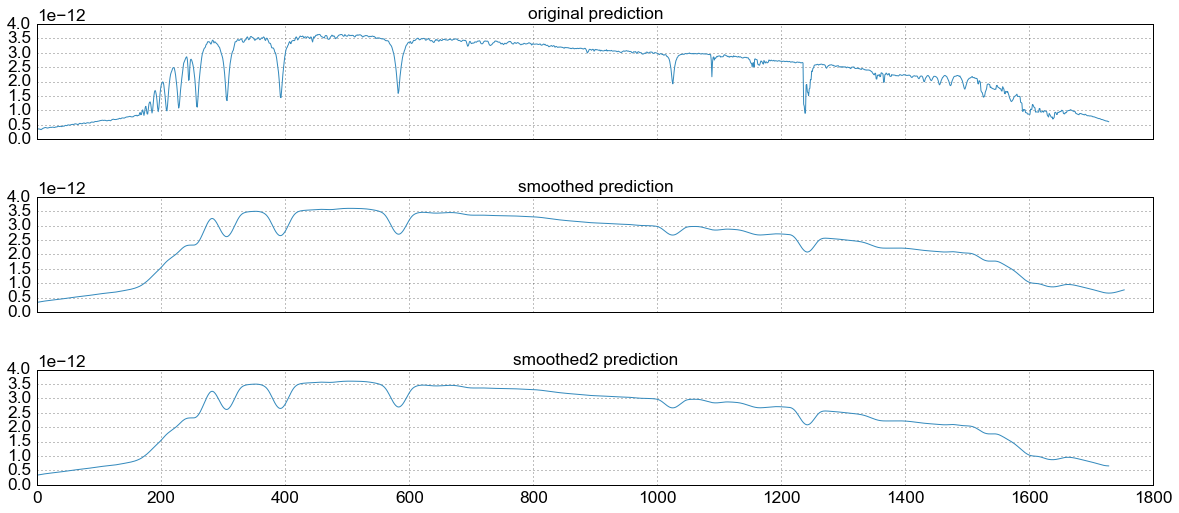

In [406]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True,figsize=(20,8))

axarr[0].plot(combined_obspred[2000:4000])
axarr[0].set_title('original prediction')
axarr[1].plot(smoothed_obspred[2000+smooth_window/2:4000])
axarr[1].set_title('smoothed prediction')
axarr[2].plot(smoothed_obspred2[2000:4000])
axarr[2].set_title('smoothed2 prediction')

## C) combine the experimental spectra 

- cut the prediction to get arrays of same size (same number of wavelength bins)

In [407]:
TableLength = []
for spectrum in spectra_list:
    TableLength.append(spectrum.shape[0])

In [408]:
print 'min Table Length = ' , min(TableLength)
print 'max Table Length = ' , max(TableLength)

min Table Length =  2583
max Table Length =  2587


In [409]:
NBWLBINS=min(TableLength) # define the final size

#### First,  store each predicted spectra in a 2D array

In [410]:
specdata_array=np.zeros((NBFILES,NBWLBINS))
wavelength_array=np.zeros((NBFILES,NBWLBINS))



In [411]:
for idx,spectrum in enumerate(spectra_list):
    spec=np.array(spectrum)
    specdata_array[idx,:]=spec[0:NBWLBINS]
    wavelength_array[idx,:]=wavelength_list[idx][0:NBWLBINS]

#### Second, Combine the preduction by calculating the average

In [412]:
combined_spectra=np.average(specdata_array,axis=0)
combined_spectra_rms=np.std(specdata_array,axis=0)
combined_wavelength=np.average(wavelength_array,axis=0)

### Comparison of predicted spectrum and experimental spectrum

In [413]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

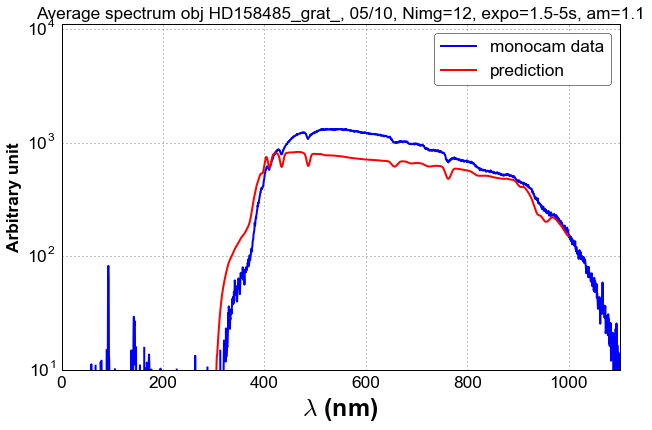

In [414]:
figname='AverageSpectrumLog_'+infofig +'.pdf'
plt.figure(figsize=(10.,6.))
plt.semilogy(combined_wavelength,combined_spectra,'b',label='monocam data',linewidth=2.0)
#plt.plot(combined_wavelengthPRED,combined_obspred*3e14,'r',label=' prediction')
plt.semilogy(combined_wavelengthPRED,smoothed_obspred2*FactorPredToData,'r',label='prediction',linewidth=2.0)
title='Average spectrum '+info
plt.title(title)
plt.xlabel('$\lambda$ (nm)',fontsize=25)
plt.ylabel('Arbitrary unit')
plt.xlim(0,1100.)
plt.ylim(10.,11000.)
plt.legend()
plt.savefig(figname)
plt.show()

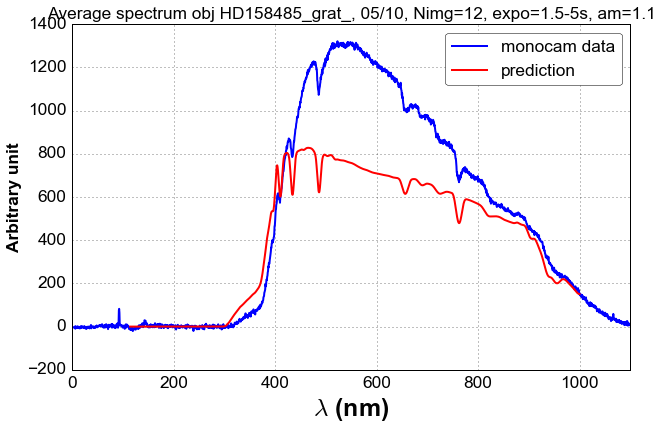

In [415]:
figname='AverageSpectrumLin_'+infofig +'.pdf'
plt.figure(figsize=(10.,6.))
plt.plot(combined_wavelength,combined_spectra,'b',label='monocam data',linewidth=2.0)
#plt.plot(combined_wavelengthPRED,combined_obspred*3e14,'r',label=' prediction')
plt.plot(combined_wavelengthPRED,smoothed_obspred2*FactorPredToData,'r',label='prediction',linewidth=2.0)
title='Average spectrum '+info
plt.title(title)
plt.xlabel('$\lambda$ (nm)',fontsize=25)
plt.ylabel('Arbitrary unit')
plt.xlim(0,1100.)
#plt.ylim(10.,11000.)
plt.legend()
plt.savefig(figname)
plt.show()

#### need to force the data and the prediction to be of the same size

- ressample the experimental data with the binning of the predicted spectrum by using
the interpolep function of numpy

In [416]:
interpolated_pred_data=np.interp(combined_wavelengthPRED,combined_wavelength,combined_spectra)

#### check the result of the interpolation

(0, 1100.0)

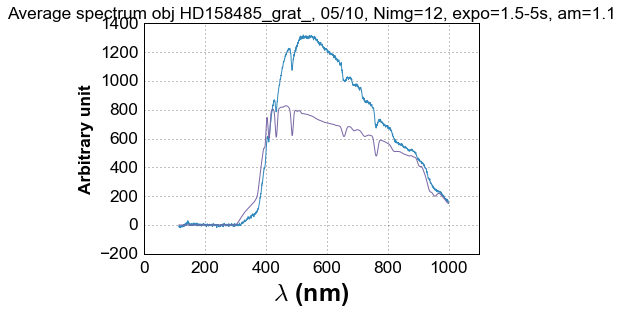

In [417]:
plt.figure(figsize=(6,4))
plt.plot(combined_wavelengthPRED, interpolated_pred_data)
plt.plot(combined_wavelengthPRED, smoothed_obspred2*FactorPredToData)
title='Average spectrum '+info
plt.title(title)
plt.xlabel('$\lambda$ (nm)',fontsize=25)
plt.ylabel('Arbitrary unit')
plt.xlim(0,1100.)

#### Cut to remove zeros in the division


- select wavelengthes larger than 400 nm

In [418]:
selected_indexes=np.where(combined_wavelengthPRED>400)
new_combined_wavelengthPRED= combined_wavelengthPRED[selected_indexes]
new_interpolated_pred_data= interpolated_pred_data[selected_indexes]
new_smoothed_obspred2= smoothed_obspred2[selected_indexes]
ratioData=new_interpolated_pred_data/(new_smoothed_obspred2*FactorPredToData)  # the ratio

ratio_smooth_window=201
ratioData_smoothed=smooth(ratioData,window_len=ratio_smooth_window,window='hanning')
ratioData_smoothed_cut=ratioData_smoothed[ratio_smooth_window/2: ratioData_smoothed.shape[0]-ratio_smooth_window/2]

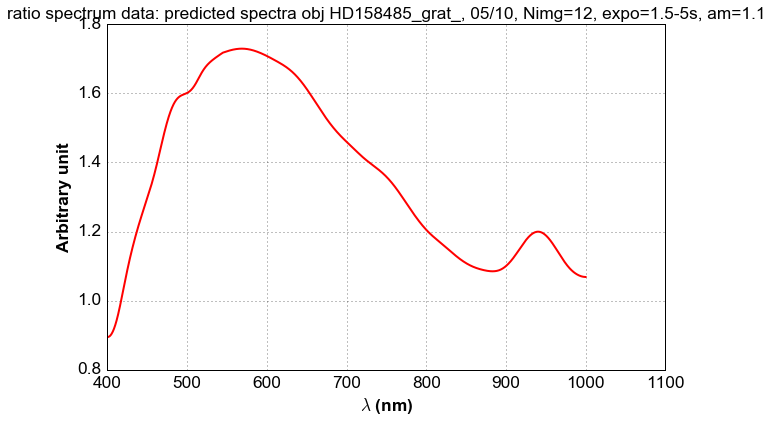

In [419]:
figname='RatioSpectrumLin_'+infofig +'.pdf'
plt.figure(figsize=(10.,6.))
plt.plot(new_combined_wavelengthPRED,ratioData_smoothed_cut,'r',label=' data/prediction',linewidth=2.0)
title = 'ratio spectrum data: predicted spectra '+info
plt.title(title)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Arbitrary unit')
plt.xlim(400,1100.)
#plt.ylim(1.,11000.)
#plt.legend()
plt.savefig(figname)
plt.show()

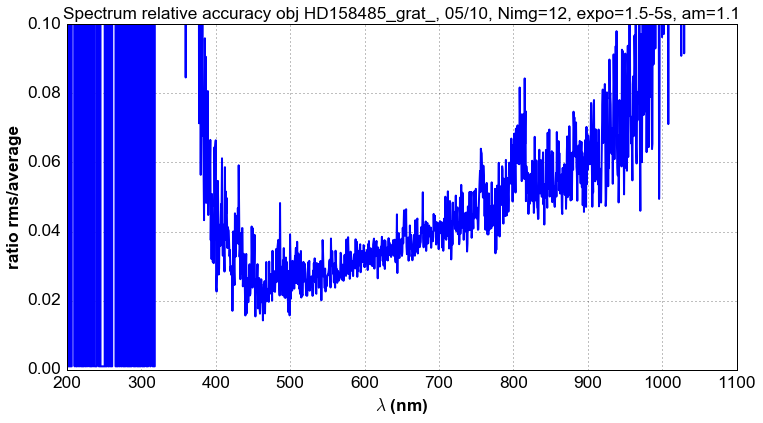

In [421]:
figname='RMSToAverSpectrumLin_'+infofig +'.pdf'
plt.figure(figsize=(12.,6.))
ratio=np.where(combined_spectra>0, combined_spectra_rms/combined_spectra,0.001)
plt.plot(combined_wavelength,ratio,color='b',linewidth=2)
#plt.ylim(0.,1.) # clouds
#plt.ylim(0.,.2) # little clouds
plt.ylim(0.,.1) # no cloud
title = 'Spectrum relative accuracy '+ info
plt.title(title)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('ratio rms/average')
plt.xlim(200.,1100)
plt.savefig(figname)